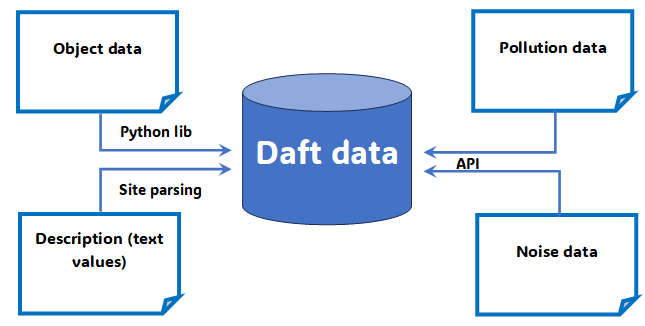

## Daft

A library that enables programmatic interaction with Daft.ie.

In [ ]:
!pip install https://github.com/AnthonyBloomer/daftlistings/archive/dev.zip

     \ 116.9 kB 2.1 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for daftlistings: filename=daftlistings-2.0.4-py3-none-any.whl size=100125 sha256=d044d56e2d2445658b39395cb602657bdf3ebaf0f3b041c7ada1119bda669a55
  Stored in directory: /tmp/pip-ephem-wheel-cache-r679lg91/wheels/19/b3/15/03e7bdb3e6608f820db81f58b39b2bb60bac69df2c894b0fad
Successfully built daftlistings


In [ ]:
from daftlistings import Daft, Location, SearchType, PropertyType, SortType, MapVisualization

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
import datetime
from dateutil.relativedelta import relativedelta
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt

In [ ]:
daft = Daft()
daft.set_location(Location.DUBLIN)

listings = daft.search()
dd = []
for listing in listings:
    pp = listing.as_dict()
    pp['publishDate'] = listing.publish_date
    dd.append(pp)
df_30_11 = pd.DataFrame(dd)
print(df_30_11.info())
#df.to_csv('Dublin.csv', index = False)

To collect more data have to add data from previous dates and merged

In [ ]:
df = pd.read_csv('Dublin_Daft_23_11.zip', compression='zip') # the previous data
df['publishDate'] = pd.to_datetime(df['publishDate'],format = "%Y-%m-%d %H:%M:%S",exact=False)
df_30_11['publishDate'] = pd.to_datetime(df_30_11['publishDate'],format = "%Y-%m-%d %H:%M:%S",exact=False)

In [ ]:
df1 = df.sort_values('publishDate')
df1_30_11 = df_30_11.sort_values('publishDate')
df2_30_11 = df1_30_11[df1_30_11['publishDate'] > df1.iloc[-1]['publishDate']]
df_merged = pd.concat([df1, df2_30_11], axis=0) # final file


## Description


In [ ]:
url = 'https://www.daft.ie'

In [ ]:
for index, row in df_merged.iterrows():
#df_merged[df_merged['publishDate'] > df1.iloc[-1]['publishDate']].iterrows():
  url_part = row['seoFriendlyPath']
  url_new = url + url_part
  r = requests.post(url_new,headers={'accept': '*/*','user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36'})
  if r.status_code == 200:
    page = BeautifulSoup(r.content, parser = 'html')
    if page.find('div',  attrs={'data-testid':'description'}) != None:
      description =  page.find('div',  attrs={'data-testid':'description'}).get_text()
      description = description.replace("Description", "", 1)
      df_merged.at[index,'description'] = description
  else:
    print(index)

In [ ]:
compression_opts = dict(method='zip',archive_name='Dublin_Daft.csv')
df_merged.to_csv('Dublin_Daft.zip', index=False, compression=compression_opts)

Sonitus API
URL: https://data.smartdublin.ie/sonitus-api

This API provides access to Sonitus noise and air quality monitoring readings for the Dublin area.

5 endpoints are available:

monitors: Get details of all of monitors

monitor / {SERIAL}: Get information for one specific monitor

data: Get real time readings for a monitor

hourly-averages: Get hourly average readings for a monitor

noise-averages: Get post processed averages for user defined time periods.

To access any of this data, you need to use the following credentials:

username: dublincityapi

password: Xpa5vAQ9ki

In [ ]:
username = 'dublincityapi'
pwd = 'Xpa5vAQ9ki'

## Monitors (https://data.smartdublin.ie/sonitus-api/api/monitors)

In [ ]:
url = 'https://data.smartdublin.ie/sonitus-api/api/monitors?username=dublincityapi&password=Xpa5vAQ9ki'
try:
    r = requests.post(url, headers={'accept': '*/*'})
    r.raise_for_status()
except requests.exceptions.HTTPError as errh:
    print("HTTP Error")
    print(errh.args[0])

In [ ]:
result = r.json()
monitors_data = pd.DataFrame(result)


## Noise (https://data.smartdublin.ie/sonitus-api/api/noise-averages)

In [ ]:
url_noise_averages = 'https://data.smartdublin.ie/sonitus-api/api/noise-averages?username=dublincityapi&password=Xpa5vAQ9ki&monitor='

In [ ]:
# end and start dates into unix format
d = datetime.date(2024,11,6) #datetime.datetime.now()
d_3 = d - relativedelta(months=6) # 3 month before
t1 = str(time.mktime(d_3.timetuple()))
t2 = str(time.mktime(d.timetuple()))

In [ ]:
df_noise_averages = pd.DataFrame()
for monitor in result:
  if 'Noise' in monitor['label']:
    m = monitor['serial_number']
    url1 = url_noise_averages + m + '&start=' + t1 + '&end=' + t2
    r1 = requests.post(url1, headers={'accept': 'application/json'})
    if r1.status_code != 200:
      print('something wrong with ',m)
      continue
    if r1.text == '' or r1.text == '[]':
      print('empty response for ',m)
      continue
    m1_data = pd.DataFrame(r1.json())
    m1_data['date'] = pd.to_datetime(m1_data['date'])
    m11 = m1_data[m1_data['start_time'] == '00:00:00']
    m12 = m1_data[m1_data['start_time'] == '23:00:00']
    m12.columns = ['date', 'start_time_night', 'end_time_night', 'laeq_night', 'limit_level_night', 'breach_night']
    m1 = pd.merge(m11, m12, on='date')
    m1['weekday'] = pd.to_datetime(m1['date'],dayfirst=True).dt.day_name()
    m1['monitor'] = m
    df_noise_averages = pd.concat([df_noise_averages, m1], axis=0)
#df_noise_averages.to_csv('df_noise_averages.csv', index = False)
#df_noise_averages

something wrong with  01508
something wrong with  10118
something wrong with  01548
something wrong with  10115
something wrong with  10.1.1.7
something wrong with  01870
something wrong with  01575
something wrong with  01737
something wrong with  10.1.1.11
something wrong with  10.1.1.12
something wrong with  01550
something wrong with  01534
something wrong with  01535
something wrong with  01509
something wrong with  01529
something wrong with  01530
something wrong with  01528


In [ ]:
df_noise_averages = pd.read_csv('df_noise_averages.csv')

In [ ]:
df_noise_averages['date'] = pd.to_datetime(df_noise_averages['date'])
df_noise_averages

,date,start_time,end_time,laeq,limit_level,breach,start_time_night,end_time_night,laeq_night,limit_level_night,breach_night,weekday,monitor
0,2024-02-06,00:00:00,23:59:00,40.3,0,0,23:00:00,07:00:00,35.1,0,0,Tuesday,10.1.1.1
1,2024-02-07,00:00:00,23:59:00,42.3,0,0,23:00:00,07:00:00,40.3,0,0,Wednesday,10.1.1.1
2,2024-02-08,00:00:00,23:59:00,43.4,0,0,23:00:00,07:00:00,41.1,0,0,Thursday,10.1.1.1
3,2024-02-09,00:00:00,23:59:00,40.9,0,0,23:00:00,07:00:00,39.0,0,0,Friday,10.1.1.1
4,2024-02-10,00:00:00,23:59:00,40.3,0,0,23:00:00,07:00:00,36.1,0,0,Saturday,10.1.1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4877,2024-11-01,00:00:00,23:59:00,37.4,0,0,23:00:00,07:00:00,35.4,0,0,Friday,01528
4878,2024-11-02,00:00:00,23:59:00,37.4,0,0,23:00:00,07:00:00,33.0,0,0,Saturday,01528
4879,2024-11-03,00:00:00,23:59:00,35.9,0,0,23:00:00,07:00:00,34.7,0,0,Sunday,01528
4880,2024-11-04,00:00:00,23:59:00,39.2,0,0,23:00:00,07:00:00,34.1,0,0,Monday,01528


## Vizualization

The noise level for the monitor with the maximum value

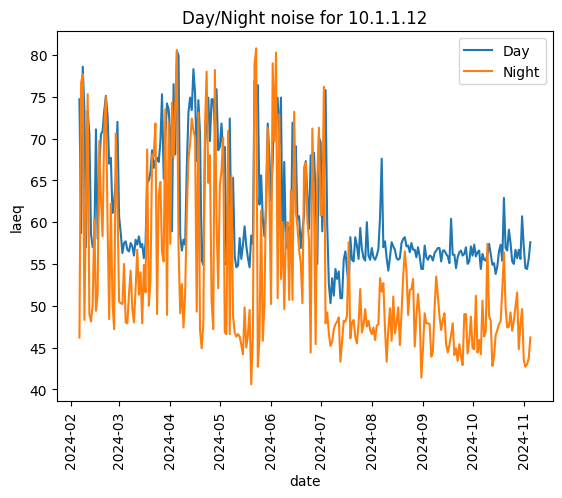

In [ ]:
max = df_noise_averages['laeq_night'].max()
mon = df_noise_averages.loc[df_noise_averages[df_noise_averages['laeq_night'] == max].index[0],'monitor']
df = df_noise_averages[df_noise_averages['monitor'] == mon]
fig, ax = plt.subplots()
ax.plot(df['date'], df['laeq'], label='Day')
ax.plot(df['date'], df['laeq_night'], label='Night')
plt.xticks(rotation=90)
plt.title('Day/Night noise for '+ mon)
ax.set_xlabel('date')
ax.set_ylabel('laeq')
ax.legend()
plt.show()

Dependence of noise on the day of the week

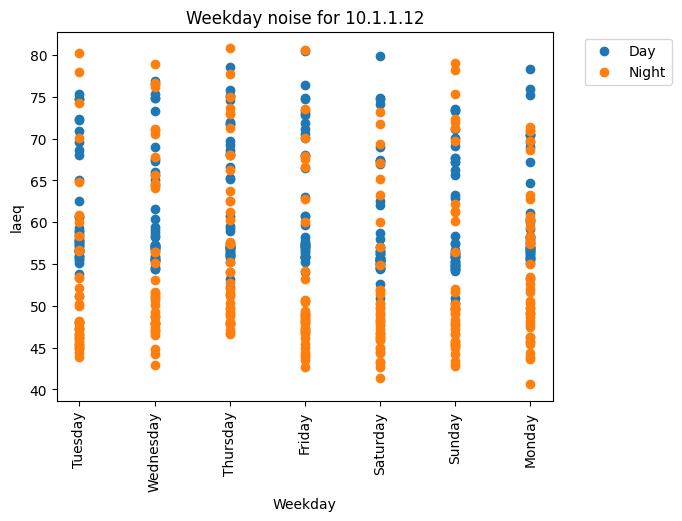

In [ ]:
fig, ax = plt.subplots()
ax.scatter(df['weekday'], df['laeq'], label='Day')
ax.scatter(df['weekday'], df['laeq_night'], label='Night')
plt.xticks(rotation=90)
plt.title('Weekday noise for '+ mon)
ax.set_xlabel('Weekday')
ax.set_ylabel('laeq')
ax.legend()
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

In [ ]:
loc = Nominatim(user_agent="GetLoc")
getLoc = loc.geocode("Dublin")
print(getLoc.address)
coordinates = [getLoc.latitude, getLoc.longitude]
print(coordinates)

Dublin, County Dublin, Leinster, Éire / Ireland
[53.3493795, -6.2605593]


In [ ]:
df_test = df_noise_averages.groupby('monitor').agg({'laeq': ['mean', 'max', 'min'],'laeq_night': ['mean', 'max', 'min']})
df_test.sort_values(by=('laeq',  'max'), ascending=False)

laeq             laeq_night            
                mean   max   min       mean   max   min
monitor                                                
10.1.1.12  61.116058  80.5  50.3  53.649635  80.8  40.6
01535      61.116058  80.5  50.3  53.649635  80.8  40.6
01508      57.998175  77.6  53.9  52.472263  58.1  49.4
01529      62.038321  76.4  57.8  58.394526  77.4  54.8
10.1.1.11  62.038321  76.4  57.8  58.394526  77.4  54.8
01509      68.811679  73.4  66.2  64.940511  70.4  62.2
01548      55.317518  71.8  51.4  50.878102  57.2  45.2
01749      47.898106  71.5  18.6  47.045455  73.7  18.5
01550      58.262082  70.5  54.8  52.892937  62.7  49.5
10118      64.451460  69.6  61.3  60.170073  64.1  58.0
01575      55.589051  69.2  51.9  50.838686  72.2  46.4
01737      54.445620  69.2  48.1  49.169343  62.0  43.0
10115      55.393305  68.2  37.2  47.033891  53.8  35.7
01534      48.893066  61.2  43.2  44.453285  55.2  36.7
10.1.1.7   48.893431  61.2  43.2  44.453285  55.2  36.7
01870      54.110219  59.5  49.9  51.429197  57.4  46.4
10.1.1.1   41.539416  53.7  35.9  37.248175  52.4  32.2
01528      41.539416  53.7  35.9  37.248175  52.4  32.2

In [ ]:
df_test['max_all'] = (df_test[('laeq',  'max')] + df_test[('laeq_night',  'max')]) / 2
df_test.sort_values(by='max_all', ascending=False)

laeq             laeq_night             max_all
                mean   max   min       mean   max   min        
monitor                                                        
10.1.1.12  61.116058  80.5  50.3  53.649635  80.8  40.6   80.65
01535      61.116058  80.5  50.3  53.649635  80.8  40.6   80.65
01529      62.038321  76.4  57.8  58.394526  77.4  54.8   76.90
10.1.1.11  62.038321  76.4  57.8  58.394526  77.4  54.8   76.90
01749      47.898106  71.5  18.6  47.045455  73.7  18.5   72.60
01509      68.811679  73.4  66.2  64.940511  70.4  62.2   71.90
01575      55.589051  69.2  51.9  50.838686  72.2  46.4   70.70
01508      57.998175  77.6  53.9  52.472263  58.1  49.4   67.85
10118      64.451460  69.6  61.3  60.170073  64.1  58.0   66.85
01550      58.262082  70.5  54.8  52.892937  62.7  49.5   66.60
01737      54.445620  69.2  48.1  49.169343  62.0  43.0   65.60
01548      55.317518  71.8  51.4  50.878102  57.2  45.2   64.50
10115      55.393305  68.2  37.2  47.033891  53.8  35.7   61.00
01870      54.110219  59.5  49.9  51.429197  57.4  46.4   58.45
01534      48.893066  61.2  43.2  44.453285  55.2  36.7   58.20
10.1.1.7   48.893431  61.2  43.2  44.453285  55.2  36.7   58.20
10.1.1.1   41.539416  53.7  35.9  37.248175  52.4  32.2   53.05
01528      41.539416  53.7  35.9  37.248175  52.4  32.2   53.05

In [ ]:
monitors_data1 = monitors_data[['serial_number','latitude','longitude']].set_index('serial_number')
df_test.columns = ['Day_mean','Day_max','Day_min','Night_mean','Night_max','Night_min','max_all']
df_test2 = df_test.join(monitors_data1)
df_test2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, 01508 to 10118
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Day_mean    18 non-null     float64
 1   Day_max     18 non-null     float64
 2   Day_min     18 non-null     float64
 3   Night_mean  18 non-null     float64
 4   Night_max   18 non-null     float64
 5   Night_min   18 non-null     float64
 6   max_all     18 non-null     float64
 7   latitude    18 non-null     float64
 8   longitude   18 non-null     float64
dtypes: float64(9)
memory usage: 1.4+ KB


In [ ]:
df_test2.to_csv('noise_coord.csv', index = False)

In [ ]:
data1 = list(map(list, zip(df_test2['latitude'],df_test2['longitude'],df_test2['max_all'])))
df_test2 = df_test2.reset_index()
map_obj = folium.Map(location = coordinates,zoom_start = 10)
df_test2.apply(lambda row:folium.Marker(location=[row["latitude"], row["longitude"]],
                                              popup = row['monitor'])
                                             .add_to(map_obj), axis=1)
#,tiles='StamenTerrain')
HeatMap(data1).add_to(map_obj)
map_obj

## Polution (https://data.smartdublin.ie/sonitus-api/api/hourly-averages)

In [ ]:
d_current = datetime.date(2024,11,6)# datetime.datetime.now()
d_initial = d_current - relativedelta(months=6)
t2 = round(time.mktime(d_current.timetuple()))
print(d_current)
print(d_initial)
times_list = []
while d_initial < d_current:
  times_list.append(d_initial)
  d_initial = d_initial + relativedelta(weeks = 3) # if the period more then 3 weeks the response is empty
times_list.append(d_current)
#print(len(times_list),times_list)
url_monitor_data = 'https://data.smartdublin.ie/sonitus-api/api/hourly-averages?username=dublincityapi&password=Xpa5vAQ9ki&monitor='
df_polution_data = pd.DataFrame()
for monitor in result:
  m = monitor['serial_number']
  print(m)
  if not 'Noise' in monitor['label']:
    for start, end in zip(times_list[:-1], times_list[1:]):
      start = str(round(time.mktime(start.timetuple())))
      end = str(round(time.mktime(end.timetuple())))
      url2 = url_monitor_data + m + '&start=' + start + '&end=' + end
      r2 = requests.post(url2, headers={'accept': 'application/json'})
      if r2.status_code != 200:
        print('something wrong with ',m, start, end, r2.status_code)
        continue
      if r2.text == '' or r2.text == '[]':
        print('empty response for ',m, start, end)
        continue
      m2_data = pd.DataFrame(r2.json())
      m2_data['date'] = m2_data['datetime'].str.split(' ', expand=True)[0]
      m2_data['time'] = m2_data['datetime'].str.split(' ', expand=True)[1]
      m2_data['date'] = pd.to_datetime(m2_data['date'])
      col = [item for item in list(m2_data.columns) if item not in ['datetime', 'time']]
      m2_data = m2_data[col].set_index('date').resample('1d').agg(['mean', 'max', 'min'])
      m2_data.insert(0, 'monitor',m)
      m2_data['monitor'] = m
      df_polution_data = pd.concat([df_polution_data, m2_data], axis=0)
df_polution_data

In [ ]:
df_polution_data.to_csv('df_polution_f.csv', index = False)